In [1]:
# Standard Library Imports
import datetime
import json
import os
import random
import uuid
from io import BytesIO
from typing import List, Optional, Union

# Third-Party Library Imports
from google.cloud import pubsub_v1
from google.cloud import storage
from PIL import Image as PILImage
import psycopg2
import requests
import vertexai
from vertexai.preview.vision_models import ImageGenerationModel

In [2]:
project_id="data-connect-demo6"
gcs_bucket_name="demo6-df-temp"
location="us-central1"
user_prompt="unicorn toy"
#print(prompt)
filename_safe_prompt=user_prompt.replace(" ", "_").lower()
print(filename_safe_prompt)
id=str(uuid.uuid4())
print(id)

unicorn_toy
ae03da3a-96b2-46fb-b69d-5f93bc24f91a


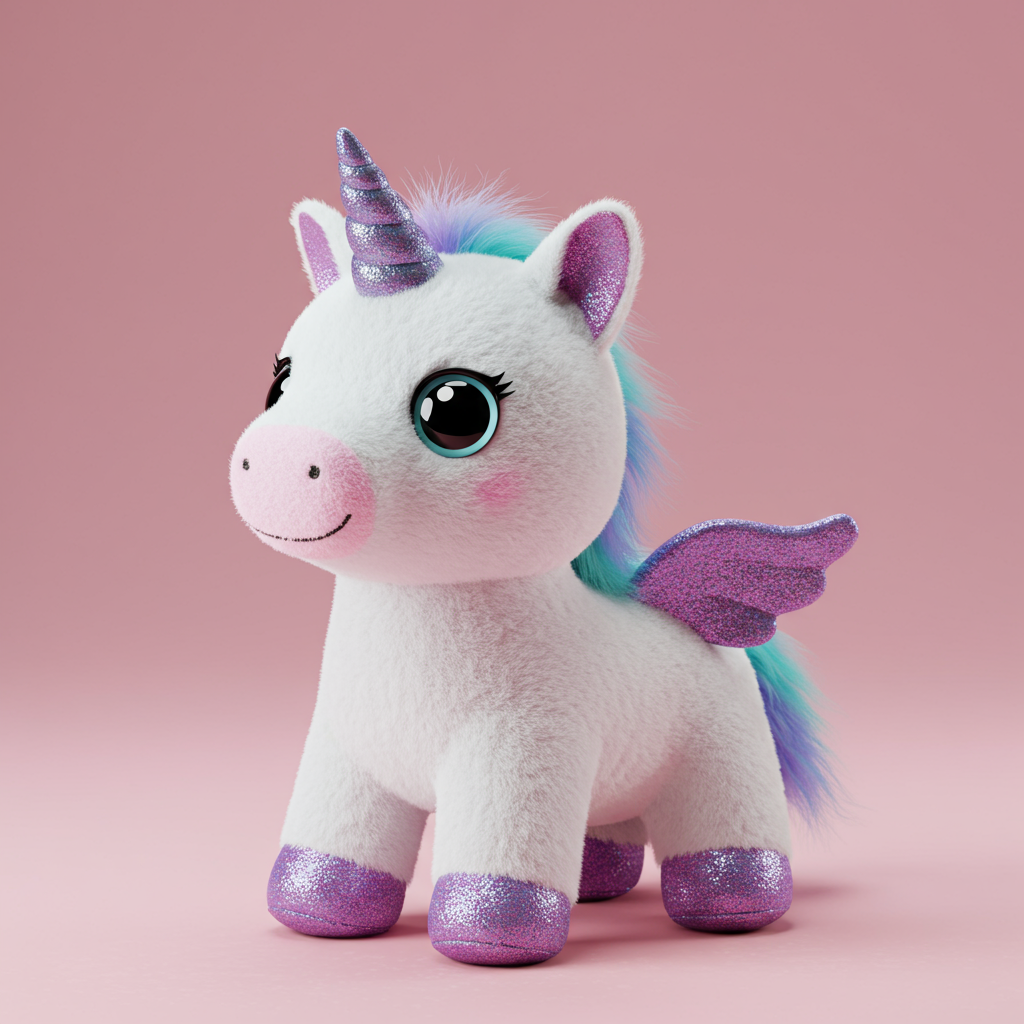

Created output image using 1065628 bytes


In [3]:
vertexai.init(project=project_id, location=location)

model = ImageGenerationModel.from_pretrained("imagen-3.0-generate-002")

images = model.generate_images(
    prompt=f'Generate images for pet toys for children. Ensure that the images are safe for work. The user prompt is {user_prompt}',
    # Optional parameters
    number_of_images=1,
    language="en",
    # You can't use a seed value and watermark at the same time.
    # add_watermark=False,
    # seed=100,
    aspect_ratio="1:1",
    safety_filter_level="block_some",
)

#images[0].save(location=output_file, include_generation_parameters=False)

# Optional. View the generated image in a notebook.
images[0].show()

print(f"Created output image using {len(images[0]._image_bytes)} bytes")
# Example response:
# Created output image using 1234567 bytes

In [4]:
    # Initialize clients
    storage_client = storage.Client()
    publisher = pubsub_v1.PublisherClient()
    topic_path = publisher.topic_path("data-connect-demo6", "demo6-topic")

In [5]:
    # 2. Upload to GCS
    image_bytes = images[0]._image_bytes  # Access the raw bytes

    # GCS Upload (directly using the raw bytes)
    timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
    image_name = f"image_{filename_safe_prompt}_{timestamp}.jpeg"  # Use .jpeg extension, as that is the default of generate_image()
    gcs_path = f"raw/{image_name}"
    bucket = storage_client.bucket(gcs_bucket_name)
    blob = bucket.blob(gcs_path)
    blob.upload_from_string(image_bytes, content_type="image/jpeg")  # Upload bytes directly
    print(f"Image uploaded to gs://{gcs_bucket_name}/{gcs_path}")

Image uploaded to gs://demo6-df-temp/raw/image_unicorn_toy_20250401003503.jpeg


In [6]:
        # 3. Publish to Pub/Sub
        message_data = {
            "id": id,
            "image_path": f"gs://{gcs_bucket_name}/{gcs_path}",
            "image_bucket": gcs_bucket_name,
            "image_path_split": gcs_path,
            "contextual_text": user_prompt,
        }
        message_bytes = json.dumps(message_data).encode("utf-8")

        try:
            publish_future = publisher.publish(topic_path, data=message_bytes)
            publish_future.result()  # Wait for the publish to complete
            print(f"Message about {image_name} with id {id} published to {topic_path}")
        except Exception as e:
            print(f"Error publishing message: {e}")

Message about image_unicorn_toy_20250401003503.jpeg with id ae03da3a-96b2-46fb-b69d-5f93bc24f91a published to projects/data-connect-demo6/topics/demo6-topic


Retrieving data from Alloy DB

In [7]:
# AlloyDB connection details

alloydb_ip = "10.85.0.2"
alloydb_port = "5432"
alloydb_database = "postgres"
alloydb_username = "testuser"

In [8]:
from google.cloud import secretmanager

# Replace with your Google Cloud project ID and secret name
project_id = "data-connect-demo6"
project_number = "230998792148"
secret_name = "alloydb_password"
version_id = 1  # Or a specific version number

# Create the Secret Manager client
client = secretmanager.SecretManagerServiceClient()

# Build the resource name of the secret version
#resource_name = "projects/230998792148/secrets/alloydb_password/versions/1"
resource_name = f"projects/{project_number}/secrets/{secret_name}/versions/{version_id}"

#print(resource_name)

# Retrieve the secret value
response = client.access_secret_version(name=resource_name)
alloydb_password = response.payload.data.decode("UTF-8")

Number of rows returned by query: 4


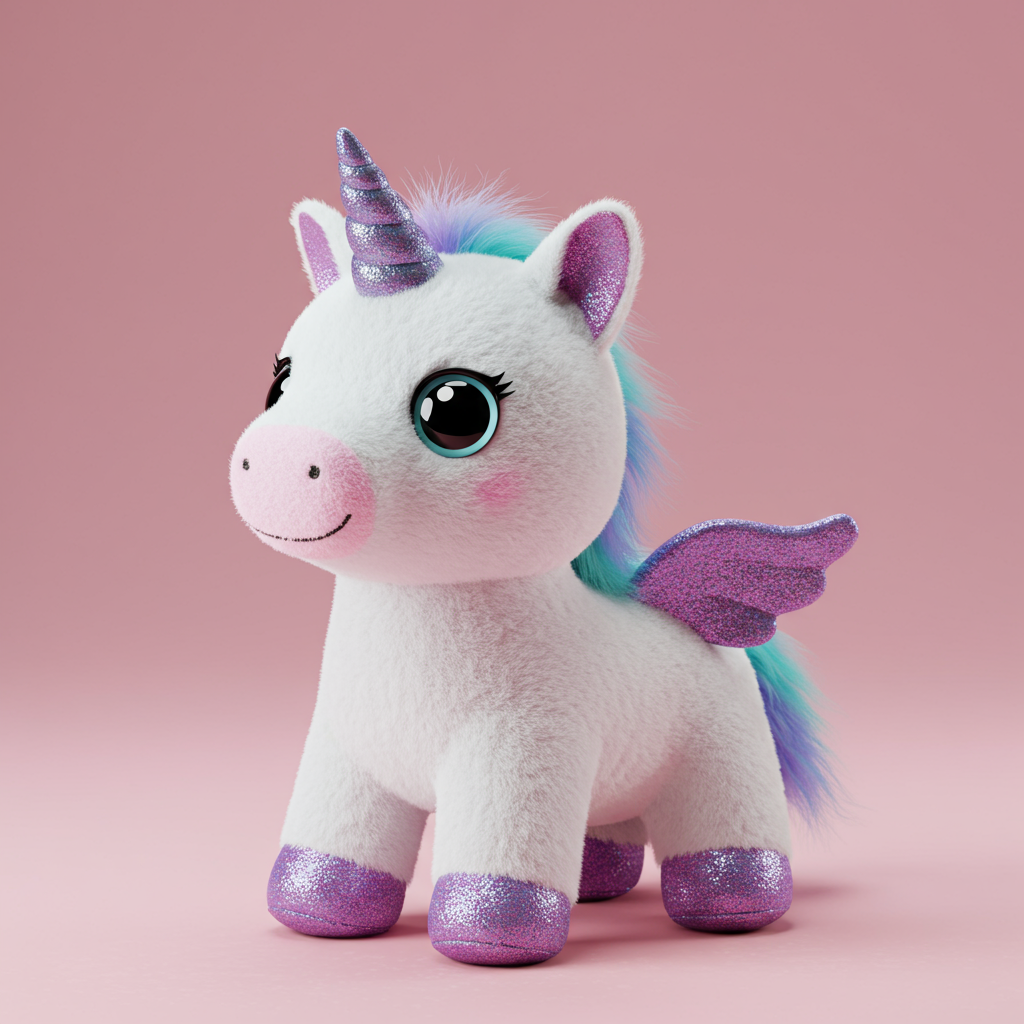

Image ID: ae03da3a-96b2-46fb-b69d-5f93bc24f91a, Distance: 0.0


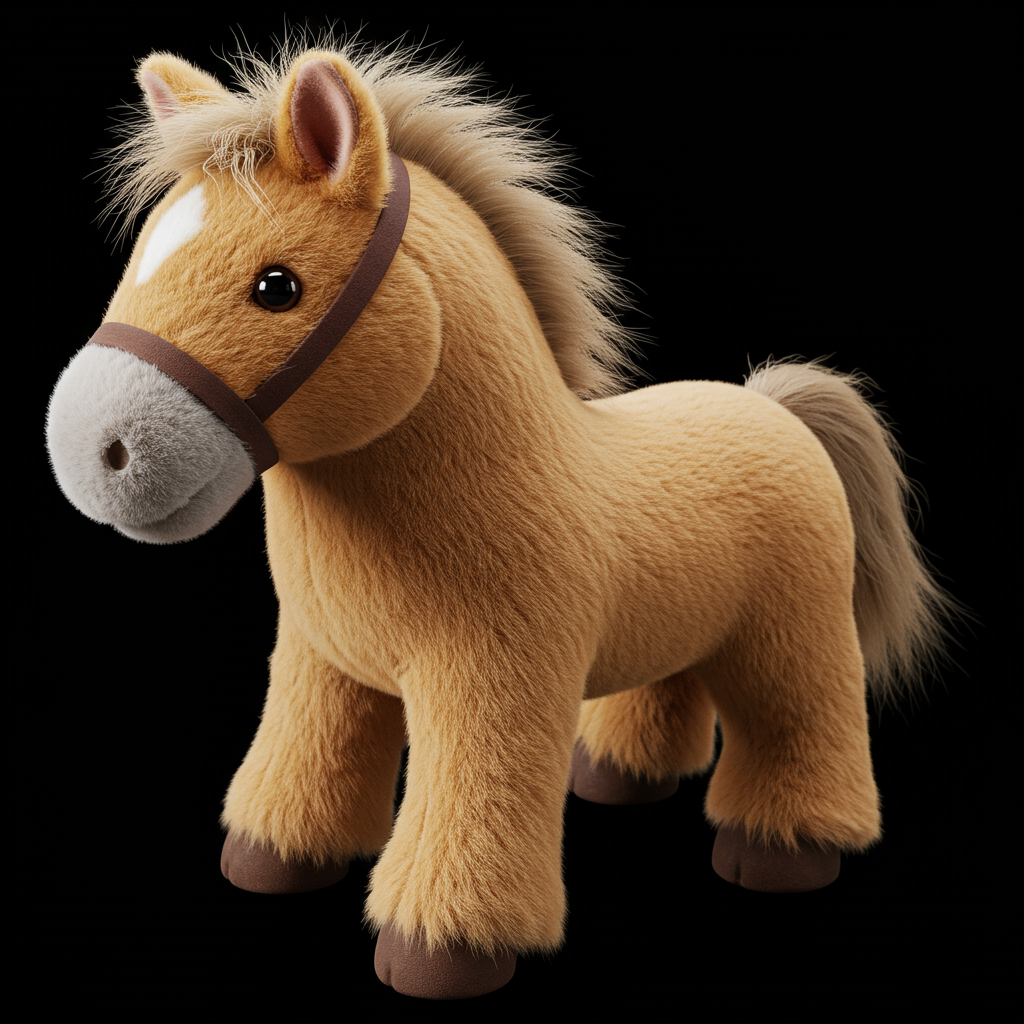

Image ID: b1420e2e-44ce-474e-a2a7-c8a7640db52a, Distance: 0.23853060466415943


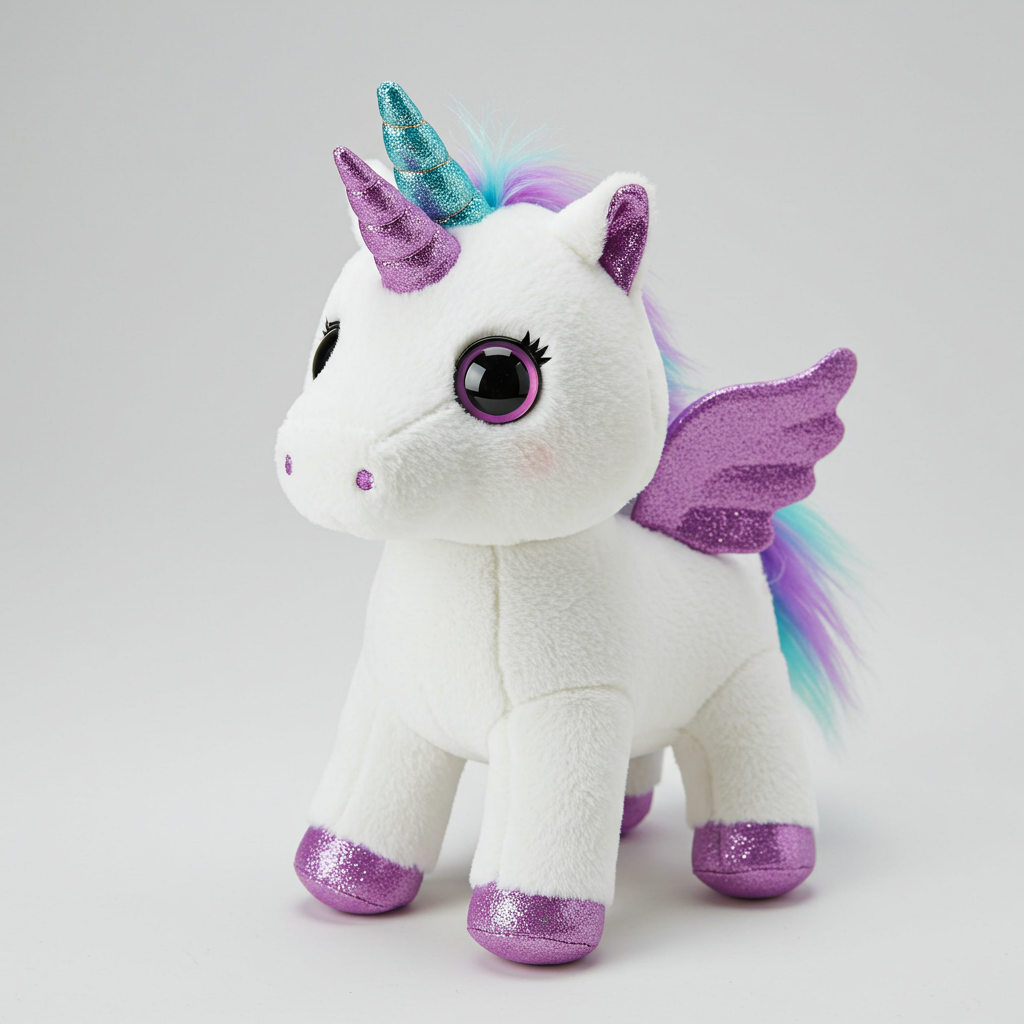

Image ID: b0933a94-e9bc-43e6-a38b-64f4d020baf8, Distance: 0.2568775415420479


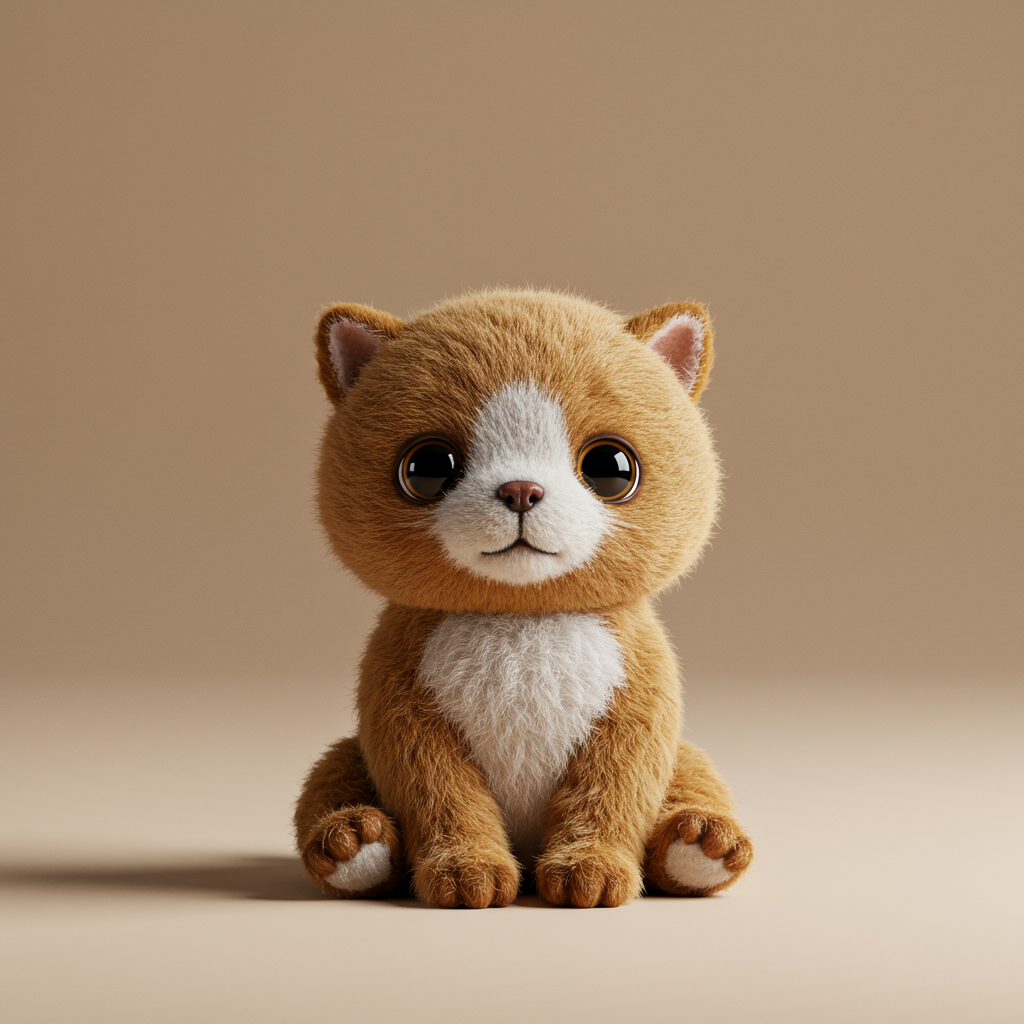

Image ID: c8002841-38c6-4f3b-9dfc-d5497034f7be, Distance: 0.28894010650397617
Connection closed.


In [10]:
import time

time.sleep(5)  # Wait for 5 seconds

try:
    # Establish a connection to AlloyDB
    conn = psycopg2.connect(
        host=alloydb_ip,
        port=alloydb_port,
        database=alloydb_database,
        user=alloydb_username,
        password=alloydb_password
    )

    # Create a cursor object to execute SQL queries
    cur = conn.cursor()

    query = """
WITH DistanceCalculation AS (
     SELECT *,
            (image_embedding::vector <=> (SELECT image_embedding::vector FROM image_embeddings2 WHERE id = %s)) AS distance
     FROM image_embeddings2
 )
 SELECT image_path, id, distance
 FROM DistanceCalculation
 WHERE distance IS NOT NULL
 ORDER BY distance ASC
 LIMIT 4;
"""

    # Example: Fetch data from a table
    cur.execute(query,(id,))
    results = cur.fetchall()
    print(f"Number of rows returned by query: {len(results)}")
 # Initialize the Google Cloud Storage client
    storage_client = storage.Client()

     # Display the top N images
    for image_path, image_id, distance in results:
         try:
             # Parse the gs:// URL
             bucket_name = image_path.split('/')[2]  # Extract the bucket name
             blob_name = '/'.join(image_path.split('/')[3:])  # Extract the blob name

             # Get the bucket and blob objects
             bucket = storage_client.bucket(bucket_name)
             blob = bucket.blob(blob_name)

             # Download the image data into BytesIO
             image_data = BytesIO()
             blob.download_to_file(image_data)
             image_data.seek(0)  # Reset the buffer position to the beginning

             # Open the image using PIL
             pil_image = PILImage.open(image_data)

             # Display the PIL image in Colab
             display(pil_image)

             print(f"Image ID: {image_id}, Distance: {distance}")

         except Exception as e:
             print(f"Error displaying image from {image_path}: {e}")

except psycopg2.Error as e:
     print(f"Error connecting to or querying AlloyDB: {e}")

finally:
     # Close the cursor and connection
     if 'cur' in locals() and cur is not None:
         cur.close()
     if 'conn' in locals() and conn is not None:
         conn.close()
         print("Connection closed.")